In [1]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns
sns.set()

# Import et EDA

In [4]:
# https://query.data.world/s/jb75k2kxn5ajlcxsmvlnorxyj4pisx
df = pd.read_csv('https://bit.ly/2Pkupqx')

df.info()

df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
churn                         5000 non-null object
accountlength                 5000 non-null int64
internationalplan             5000 non-null object
voicemailplan                 5000 non-null object
numbervmailmessages           5000 non-null int64
totaldayminutes               5000 non-null float64
totaldaycalls                 5000 non-null int64
totaldaycharge                5000 non-null float64
totaleveminutes               5000 non-null float64
totalevecalls                 5000 non-null int64
totalevecharge                5000 non-null float64
totalnightminutes             5000 non-null float64
totalnightcalls               5000 non-null int64
totalnightcharge              5000 non-null float64
totalintlminutes              5000 non-null float64
totalintlcalls                5000 non-null int64
totalintlcharge               5000 non-null float64
numbercustomerservicecal

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,numbercustomerservicecalls
1396,No,140,yes,yes,27,188.9,124,32.11,160.9,102,13.68,197.7,100,8.90,11.5,5,3.11,4
3207,No,93,no,yes,22,306.2,123,52.05,189.7,83,16.12,240.3,107,10.81,11.7,2,3.16,0
190,No,107,no,no,0,133.8,85,22.75,180.5,94,15.34,112.2,115,5.05,8.9,4,2.40,0


In [7]:
df.describe()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,numbercustomerservicecalls
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,100.25860,7.755200,180.288900,100.029400,30.649668,200.636560,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400
std,39.69456,13.546393,53.894699,19.831197,9.162069,50.551309,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.00000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,100.00000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.00000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.00000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


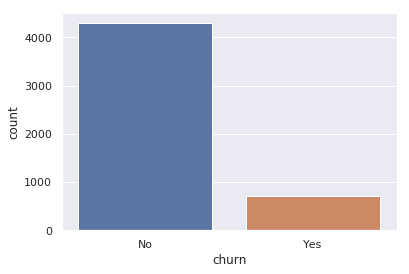

In [5]:
sns.countplot(df['churn'])
plt.show()

In [10]:
df['churn'].value_counts() / len(df)

No     0.8586
Yes    0.1414
Name: churn, dtype: float64

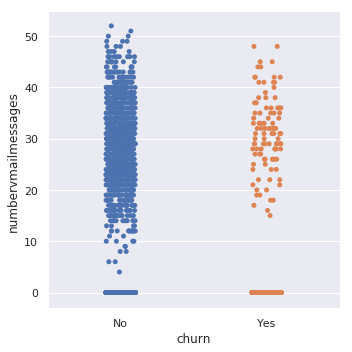

In [11]:
sns.catplot(x='churn', y='numbervmailmessages', data=df)
plt.show()

/home/girardea/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


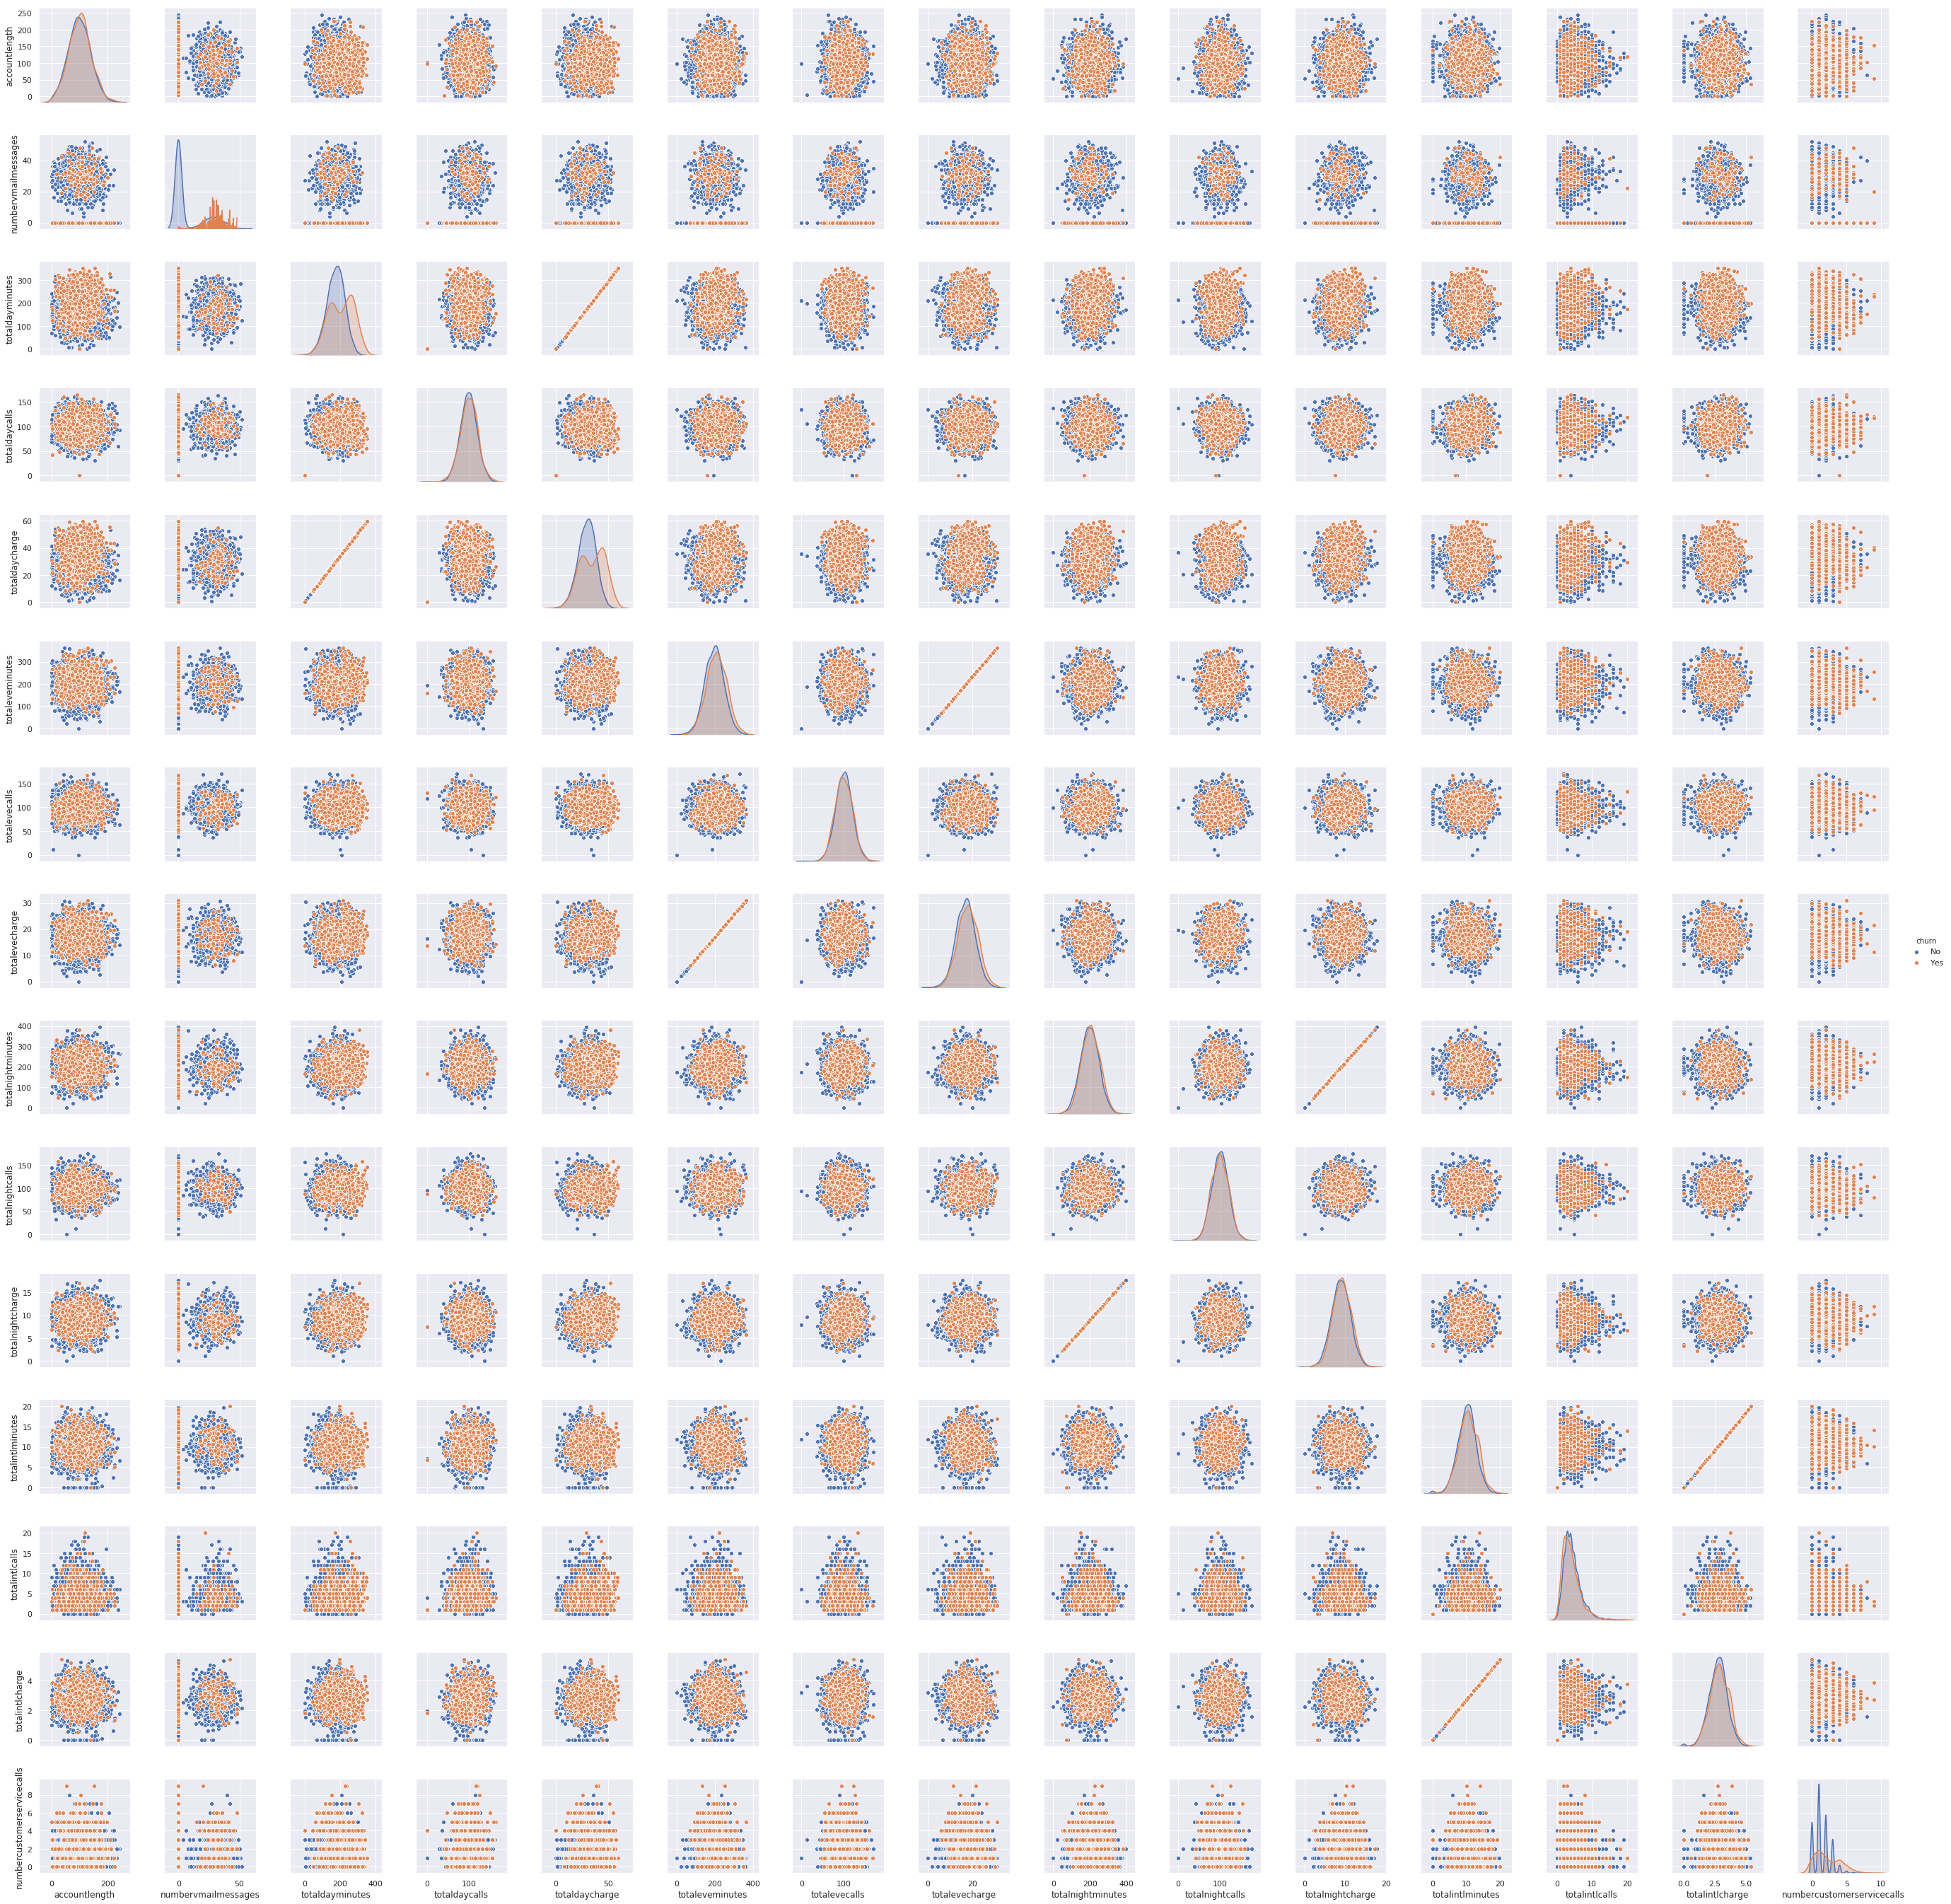

In [6]:
sns.pairplot(df, hue='churn')
plt.show()

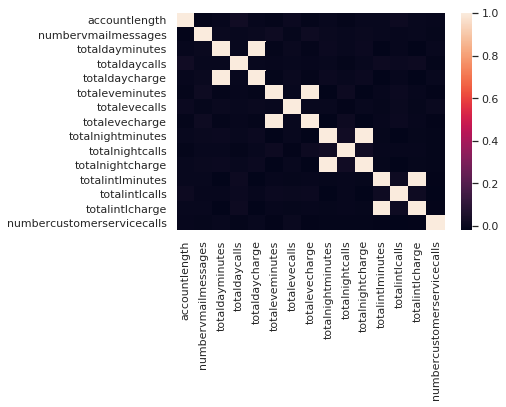

In [12]:
sns.heatmap(df.corr())
plt.show()

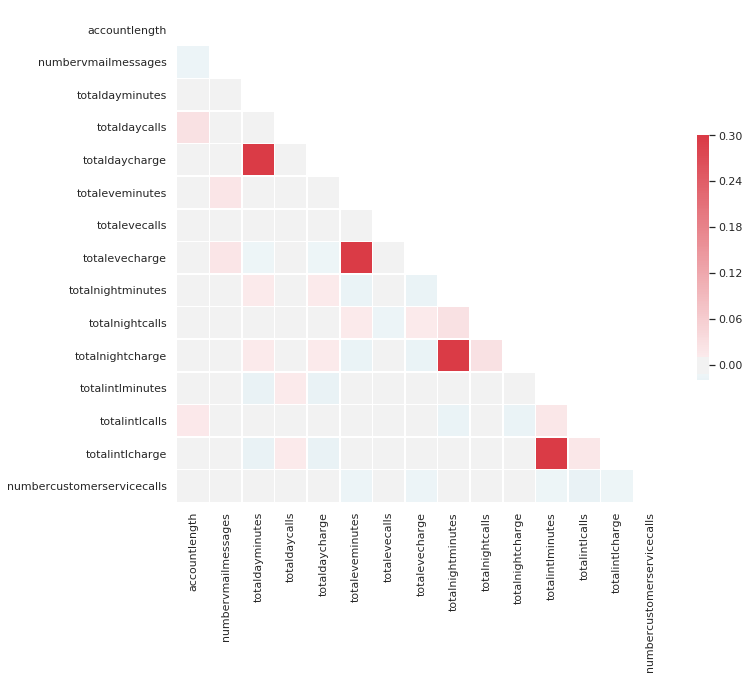

In [8]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style(style="white"):
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
for col in ['totaldaycharge', 'totalevecharge', 'totalnightcharge',
            'totalintlcharge']:
    del df[col]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [25]:
X = df[[col for col in df.columns if col not in ['churn', 'internationalplan',
                                                 'voicemailplan']]]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y)

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9173333333333333

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(rfc.predict(X_test), y_test))

              precision    recall  f1-score   support

          No       0.99      0.92      0.95      1382
         Yes       0.49      0.87      0.62       118

   micro avg       0.92      0.92      0.92      1500
   macro avg       0.74      0.90      0.79      1500
weighted avg       0.95      0.92      0.93      1500



In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

In [8]:
X = df[[col for col in df if col != 'churn']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [9]:
drop_str_cols = ColumnTransformer(transformers=[
                                      ('drop_str_cols', 'drop', ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf_lr_v0 = Pipeline(steps=[
    ('drop_str_cols', drop_str_cols),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])

clf_lr_v0.fit(X_train, y_train)

clf_lr_v0.score(X_test, y_test)

0.8626666666666667

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [11]:
enc_str_cols = ColumnTransformer(transformers=[
                                      ('enc_str_cols', OneHotEncoder(), ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf_lr_v1 = Pipeline(steps=[
    ('enc_str_cols', enc_str_cols),
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])

clf_lr_v1.fit(X_train, y_train)

clf_lr_v1.score(X_test, y_test)

0.8706666666666667

In [16]:
nb = 10

df_res = pd.concat([
    pd.DataFrame({
        'classifier': 'clf_lr_v0',
        'score': cross_val_score(clf_lr_v0, X, y, cv=2)
    }),
    pd.DataFrame({
        'classifier': 'clf_lr_v1',
        'score': cross_val_score(clf_lr_v1, X, y, cv=2)
    })
])

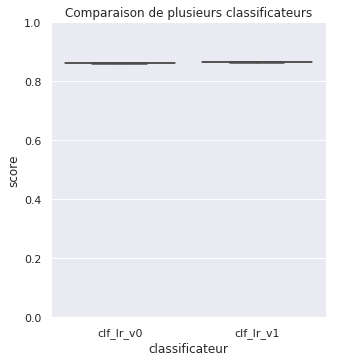

In [17]:
ax = sns.catplot(y='score', x='classifier', kind='box', data=df_res)

ax.set(
    title="Comparaison de plusieurs classificateurs",
    xlabel="classificateur",
    ylabel="score",
    ylim=[0, 1]
)

plt.show()

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
X = df[[col for col in df if col not in ['internationalplan', 'churn', 'voicemailplan']]]
y = df['churn']

nb = 10

df_res = pd.DataFrame()

for i in range(X.shape[1]):
    Xt = X.iloc[:, :i+1]
    
    clf = GradientBoostingClassifier()
    
    df_res = pd.concat([
        df_res,
        pd.DataFrame({
            'classifier': f'clf_nb_{i}',
            'score': cross_val_score(clf, Xt, y, cv=nb, scoring='roc_auc')
        })
    ])
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


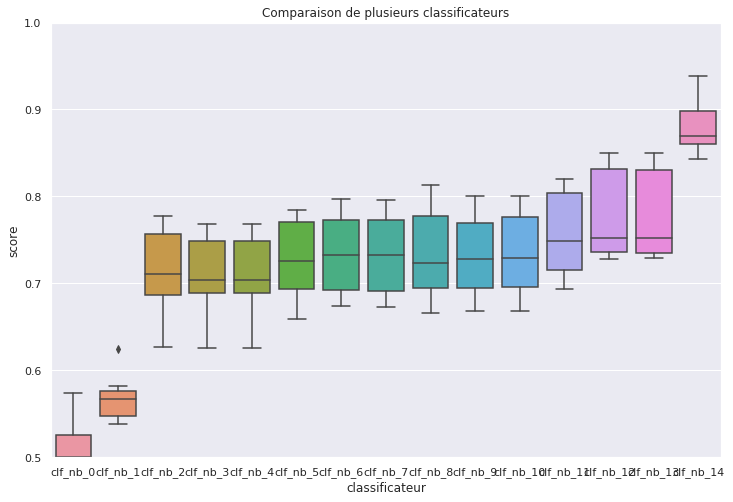

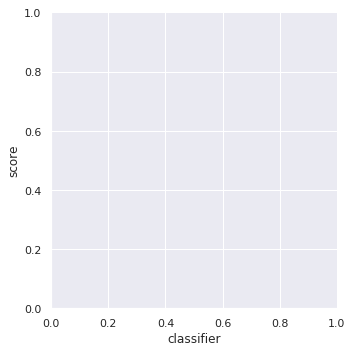

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.catplot(y='score', x='classifier', kind='box', data=df_res, ax=ax)

ax.set(
    title="Comparaison de plusieurs classificateurs",
    xlabel="classificateur",
    ylabel="score",
    ylim=[0.5, 1]
)

plt.show()

In [36]:
X.columns

Index(['accountlength', 'numbervmailmessages', 'totaldayminutes',
       'totaldaycalls', 'totaldaycharge', 'totaleveminutes', 'totalevecalls',
       'totalevecharge', 'totalnightminutes', 'totalnightcalls',
       'totalnightcharge', 'totalintlminutes', 'totalintlcalls',
       'totalintlcharge', 'numbercustomerservicecalls'],
      dtype='object')

In [37]:
X = df[[col for col in df if col != 'churn']]
y = df['churn']

nb = 10

enc_str_cols = ColumnTransformer(transformers=[
                                      ('enc_str_cols', OneHotEncoder(), ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf = Pipeline(steps=[
    ('enc_str_cols', enc_str_cols),
    ('scale', StandardScaler()),
    ('grad', GradientBoostingClassifier())
])

scores = cross_val_score(clf, X, y, cv=nb, scoring='roc_auc')

In [38]:
np.mean(scores)

0.9197867232669067

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.96      0.99      0.97      1288
         Yes       0.91      0.77      0.83       212

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.93      0.88      0.90      1500
weighted avg       0.95      0.96      0.95      1500



In [43]:
print(confusion_matrix(y_test, y_pred))

[[1271   17]
 [  49  163]]


In [46]:
163 / (49 + 163)

0.7688679245283019